<a href="https://colab.research.google.com/github/SimplifyingElectronics/Supervised-Machine-Learning/blob/main/3_C1_W2_Lab03_Feature_Scaling_and_Learning_Rate_Soln_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optional Lab: Feature scaling and Learning Rate (Multi-variable)

## Goals
In this lab you will:
- Utilize  the multiple variables routines developed in the previous lab
- run Gradient Descent on a data set with multiple features
- explore the impact of the *learning rate alpha* on gradient descent
- improve performance of gradient descent by *feature scaling* using z-score normalization

## Tools
You will utilize the functions developed in the last lab as well as matplotlib and NumPy.

In [6]:
!git clone 'https://github.com/SimplifyingElectronics/Supervised-Machine-Learning.git'
%cd Supervised-Machine-Learning

/content/Supervised-Machine-Learning


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_multi import  load_house_data, run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc
np.set_printoptions(precision=2)
plt.style.use('./deeplearning.mplstyle')

## Notation

|General <br />  Notation  | Description| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train`
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at  $\mathbf{x}^{(i)}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` |
|$\frac{\partial J(\mathbf{w},b)}{\partial w_j}$| the gradient or partial derivative of cost with respect to a parameter $w_j$ |`dj_dw[j]`|
|$\frac{\partial J(\mathbf{w},b)}{\partial b}$| the gradient or partial derivative of cost with respect to a parameter $b$| `dj_db`|

#  Problem Statement

As in the previous labs, you will use the motivating example of housing price prediction. The training data set contains many examples with 4 features (size, bedrooms, floors and age) shown in the table below. Note, in this lab, the Size feature is in sqft while earlier labs utilized 1000 sqft.  This data set is larger than the previous lab.

We would like to build a linear regression model using these values so we can then predict the price for other houses - say, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.

##  Dataset:
| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


In [15]:
# load the dataset
X_train, y_train = load_house_data()
X_features = ['size(sqft)','bedrooms','floors','age']

Let's view the dataset and its features by plotting each feature versus price.

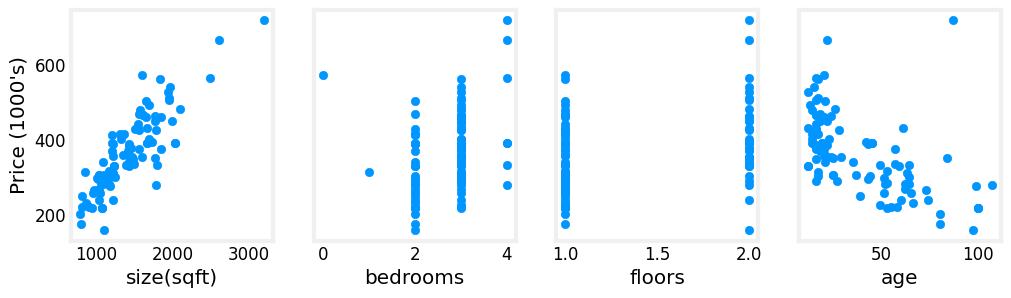

In [16]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Plotting each feature vs. the target, price, provides some indication of which features have the strongest influence on price. Above, increasing size also increases price. Bedrooms and floors don't seem to have a strong impact on price. Newer houses have higher prices than older houses.

<a name="toc_15456_5"></a>
## Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


## Learning Rate
<figure>
    <img src="https://github.com/SimplifyingElectronics/Supervised-Machine-Learning/blob/main/images/C1_W2_Lab06_learningrate.PNG?raw=1" style="width:1200px;" >
</figure>
The lectures discussed some of the issues related to setting the learning rate $\alpha$. The learning rate controls the size of the update to the parameters. See equation (1) above. It is shared by all the parameters.  

Let's run gradient descent and try a few settings of $\alpha$ on our data set

### $\alpha$ = 9.9e-7

In [17]:
#set alpha to 9.9e-7
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9.9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.55884e+04  5.5e-01  1.0e-03  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.28213e+05 -8.8e-02 -1.7e-04 -1.0e-04 -3.4e-03 -4.8e-05  6.4e+05  1.2e+03  6.2e+02  1.6e+04  4.1e+02
        2 1.72159e+05  6.5e-01  1.2e-03  5.9e-04  1.3e-02  4.3e-04 -7.4e+05 -1.4e+03 -7.0e+02 -1.7e+04 -4.9e+02
        3 2.31358e+05 -2.1e-01 -4.0e-04 -2.3e-04 -7.5e-03 -1.2e-04  8.6e+05  1.6e+03  8.3e+02  2.1e+04  5.6e+02
        4 3.11100e+05  7.9e-01  1.4e-03  7.1e-04  1.5e-02  5.3e-04 -1.0e+06 -1.8e+03 -9.5e+02 -2.3e+04 -6.6e+02
        5 4.18517e+05 -3.7e-01 -7.1e-04 -4.0e-04 -1.3e-02 -2.1e-04  1.2e+06  2.1e+03  1.1e+03  2.8e+04  7.5e+02
        6 5.63212e+05  9.7e-01  1.7e-03  8.7e-04  1.8e-02  6.6e-04 -1.3e+06 -2.5e+03 -1.3e+03 -3.1e+04 -

It appears the learning rate is too high.  The solution does not converge. Cost is *increasing* rather than decreasing. Let's plot the result:

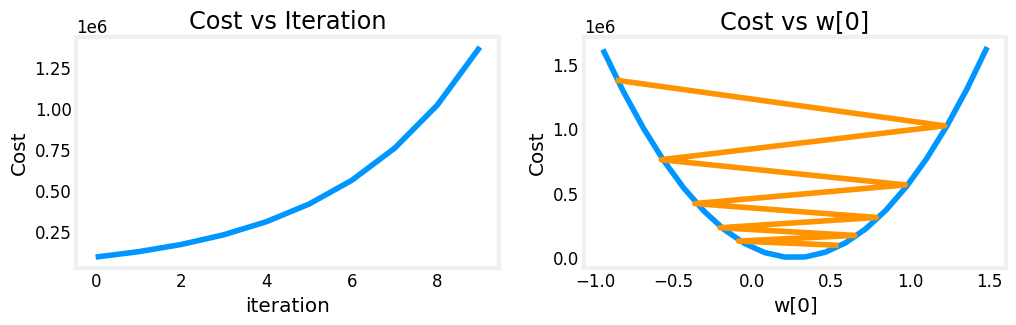

In [18]:
plot_cost_i_w(X_train, y_train, hist)

The plot on the right shows the value of one of the parameters, $w_0$. At each iteration, it is overshooting the optimal value and as a result, cost ends up *increasing* rather than approaching the minimum. Note that this is not a completely accurate picture as there are 4 parameters being modified each pass rather than just one. This plot is only showing $w_0$ with the other parameters fixed at benign values. In this and later plots you may notice the blue and orange lines being slightly off.


### $\alpha$ = 9e-7
Let's try a bit smaller value and see what happens.

In [19]:
#set alpha to 9e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.64616e+04  5.0e-01  9.1e-04  4.7e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 6.18990e+04  1.8e-02  2.1e-05  2.0e-06 -7.9e-04  1.9e-05  5.3e+05  9.8e+02  5.2e+02  1.3e+04  3.4e+02
        2 5.76572e+04  4.8e-01  8.6e-04  4.4e-04  9.5e-03  3.2e-04 -5.1e+05 -9.3e+02 -4.8e+02 -1.1e+04 -3.4e+02
        3 5.37137e+04  3.4e-02  3.9e-05  2.8e-06 -1.6e-03  3.8e-05  4.9e+05  9.1e+02  4.8e+02  1.2e+04  3.2e+02
        4 5.00474e+04  4.6e-01  8.2e-04  4.1e-04  8.0e-03  3.2e-04 -4.8e+05 -8.7e+02 -4.5e+02 -1.1e+04 -3.1e+02
        5 4.66388e+04  5.0e-02  5.6e-05  2.5e-06 -2.4e-03  5.6e-05  4.6e+05  8.5e+02  4.5e+02  1.2e+04  2.9e+02
        6 4.34700e+04  4.5e-01  7.8e-04  3.8e-04  6.4e-03  3.2e-04 -4.4e+05 -8.1e+02 -4.2e+02 -9.8e+03 -

Cost is decreasing throughout the run showing that alpha is not too large.

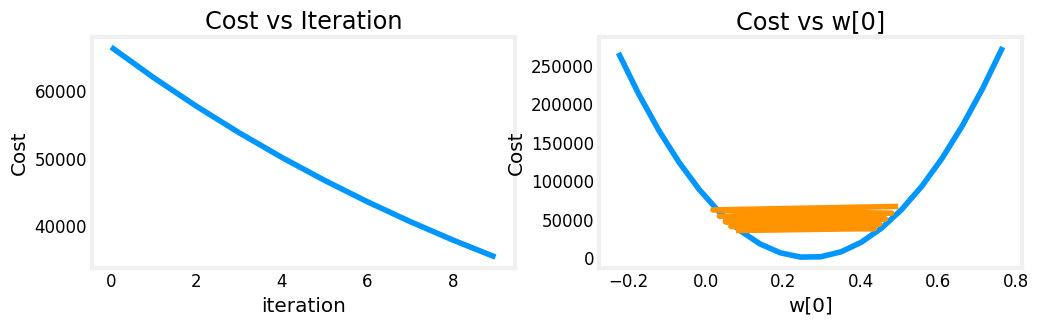

In [20]:
plot_cost_i_w(X_train, y_train, hist)

On the left, you see that cost is decreasing as it should. On the right, you can see that $w_0$ is still oscillating around the minimum, but the cost is decreasing with every iteration rather than increasing. Note above that `dj_dw[0]` changes sign with each iteration as `w[0]` jumps over the optimal value.
This alpha value will converge. You can vary the number of iterations to see how it behaves.

### $\alpha$ = 1e-7
Let's try a bit smaller value for $\alpha$ and see what happens.

In [22]:
#set alpha to 1e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.42313e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 2.76461e+04  9.8e-02  1.8e-04  9.2e-05  2.2e-03  6.5e-05 -4.3e+05 -7.9e+02 -4.0e+02 -9.5e+03 -2.8e+02
        2 1.75102e+04  1.3e-01  2.4e-04  1.2e-04  2.9e-03  8.7e-05 -3.4e+05 -6.1e+02 -3.1e+02 -7.3e+03 -2.2e+02
        3 1.13157e+04  1.6e-01  2.9e-04  1.5e-04  3.5e-03  1.0e-04 -2.6e+05 -4.8e+02 -2.4e+02 -5.6e+03 -1.8e+02
        4 7.53002e+03  1.8e-01  3.3e-04  1.7e-04  3.9e-03  1.2e-04 -2.1e+05 -3.7e+02 -1.9e+02 -4.2e+03 -1.4e+02
        5 5.21639e+03  2.0e-01  3.5e-04  1.8e-04  4.2e-03  1.3e-04 -1.6e+05 -2.9e+02 -1.5e+02 -3.1e+03 -1.1e+02
        6 3.80242e+03  2.1e-01  3.8e-04  1.9e-04  4.5e-03  1.4e-04 -1.3e+05 -2.2e+02 -1.1e+02 -2.3e+03 -

Cost is decreasing throughout the run showing that $\alpha$ is not too large.

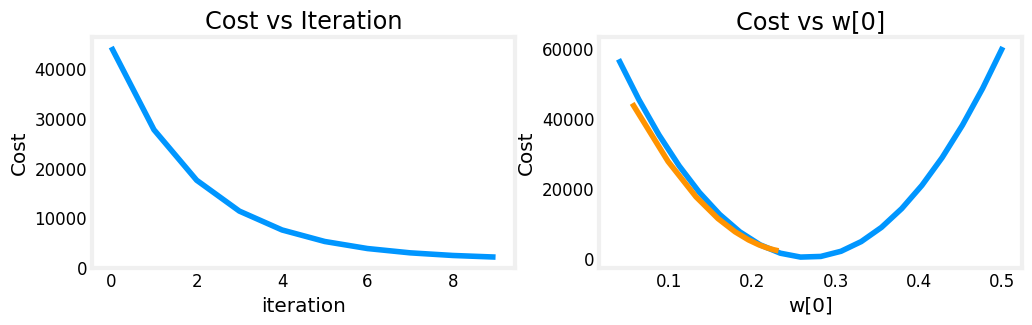

In [23]:
plot_cost_i_w(X_train,y_train,hist)

On the left, you see that cost is decreasing as it should. On the right, you can see that $w_0$ is approaching the minimum without oscillations. `dj_w0` is negative throughout the run. This solution will also converge.

## Feature Scaling
<figure>
    <img src="https://github.com/SimplifyingElectronics/Supervised-Machine-Learning/blob/main/images/C1_W2_Lab06_featurescalingheader.PNG?raw=1" style="width:1200px;" >
</figure>
The lectures described the importance of rescaling the dataset so the features have a similar range.
If you are interested in the details of why this is the case, click on the 'details' header below. If not, the section below will walk through an implementation of how to do feature scaling.